# Darcy equation

In this tutorial we present how to solve a Darcy equation with [PyGeoN](https://github.com/compgeo-mox/pygeon).  The unknowns are the velocity $q$ and the pressure $p$.

Let $\Omega=(0,1)^2$ with boundary $\partial \Omega$ and outward unit normal ${\nu}$. Given 
$k$ the matrix permeability and $g$ a vector source term, we want to solve the following problem: find $({q}, p)$ such that
$$
\left\{
\begin{array}{ll}
\begin{array}{l} 
k^{-1} {q} + \nabla p = {g}\\
\nabla \cdot {q} = 0
\end{array}
&\text{in } \Omega
\end{array}
\right.
$$
with boundary conditions:
$$ p = 0 \text{ on } \partial_{top} \Omega \qquad p = 1 \text{ on } \partial_{bottom} \Omega \qquad \nu \cdot q = 0 \text{ on } \partial_{left} \Omega \cup \partial_{right} \Omega$$

We present *step-by-step* how to create the grid, declare the problem data, and finally solve the problem.

First we import some of the standard modules. Since PyGeoN is based on [PorePy](https://github.com/pmgbergen/porepy) we import both modules.

In [1]:
import os
import numpy as np
import scipy.sparse as sps

import porepy as pp
import pygeon as pg

We create now the grid, since we will use a Raviart-Thomas approximation for ${q}$ we are restricted to simplices. In this example we consider a 2-dimensional structured grid, but the presented code will work also in 1d and 3d. PyGeoN works with mixed-dimensional grids, so we need to convert the grid.

In [2]:
mesh_size = 0.1
dim = 2

sd = pg.unit_grid(dim, mesh_size, as_mdg=False)
sd.compute_geometry()

We define now the finite element spaces for all the variables.

In [3]:
key = "darcy"

rt0 = pg.RT0(key)
p0 = pg.PwConstants(key)

# build the degrees of freedom
dofs = np.array([rt0.ndof(sd), p0.ndof(sd)])

With the following code we set the data, in particular the permeability tensor and the boundary conditions. Since we need to identify each side of $\partial \Omega$ we need few steps.

In [4]:
# inverse of the permeability tensor
inv_perm = pp.SecondOrderTensor(np.ones(sd.num_cells))
param = {pg.SECOND_ORDER_TENSOR: inv_perm}

data = pp.initialize_data({}, key, param)

# with the following steps we identify the portions of the boundary
# to impose the boundary conditions
left = np.isclose(sd.face_centers[0, :], 0)
right = np.isclose(sd.face_centers[0, :], 1)
bottom = np.isclose(sd.face_centers[1, :], 0)
top = np.isclose(sd.face_centers[1, :], 1)

# assemble the boundary conditions
bottom_top = np.logical_or(bottom, top)
bc_val = -rt0.assemble_nat_bc(sd, lambda pt: pt[1], bottom_top)

bc_ess = np.zeros(dofs.sum(), dtype=bool)
bc_ess[: dofs[0]] = np.logical_or(left, right)


# assemble a vector source term
def vector_source_fct(_):
    return np.array([0, -1, 0])


M = rt0.assemble_mass_matrix(sd)
vector_source = M @ rt0.interpolate(sd, vector_source_fct)

Once the data are assigned to the mixed-dimensional grid, we construct the matrices. In particular, the linear system associated with the equation is given as
$$
\left(
\begin{array}{cc} 
M & -B^\top\\
B & 0
\end{array}
\right)
\left(
\begin{array}{c} 
q\\ 
p
\end{array}
\right)
=\left(
\begin{array}{c} 
p_{\partial} + g\\ 
0
\end{array}
\right)
$$<br>
where $p_{\partial}$ is the vector associated to the pressure boundary contions. To construct the saddle-point problem, we rely on the `scipy.sparse` function `bmat`. Once the matrix is created, we also construct the right-hand side containing the boundary conditions.

In [5]:
# construct the local matrices
M = rt0.assemble_mass_matrix(sd, data)
B = p0.assemble_mass_matrix(sd) @ rt0.assemble_diff_matrix(sd)

# assemble the saddle point problem
spp = sps.block_array(
    [
        [M, -B.T],
        [B, None],
    ],
    format="csc",
)

# assemble the right-hand side
rhs = np.zeros(dofs.sum())
rhs[: dofs[0]] += np.hstack(bc_val) + np.hstack(vector_source)

We need to solve the linear system, PyGeoN provides a framework for that. The actual imposition of essential boundary conditions (flux boundary conditions) might change the symmetry of the global system, the class `pg.LinearSystem` preserves this structure by internally eliminating these degrees of freedom. Once the problem is solved, we extract the two solutions $q$ and $p$.

In [6]:
# solve the problem
ls = pg.LinearSystem(spp, rhs)
ls.flag_ess_bc(np.hstack(bc_ess), np.zeros(dofs.sum()))
x = ls.solve()

# split the solution into the components
idx = np.cumsum(dofs[:-1])
q, p = np.split(x, idx)

Since the computed $q$ is one value per facet of the grid, for visualization purposes we project the flux in each cell center as vector. We finally export the solution.

In [7]:
# post process variables
proj_q = rt0.eval_at_cell_centers(sd)
cell_q = (proj_q @ q).reshape((3, -1))

cell_p = p0.eval_at_cell_centers(sd) @ p

# export the solution
folder_name = os.path.join(os.getcwd(), key)
file_name = "sol"

save = pp.Exporter(sd, file_name, folder_name=folder_name)
save.write_vtu([("cell_q", cell_q), ("cell_p", cell_p)])

A representation of the computed solution is given below, where the cells are colored with $p$ and the arrows are the $q$.

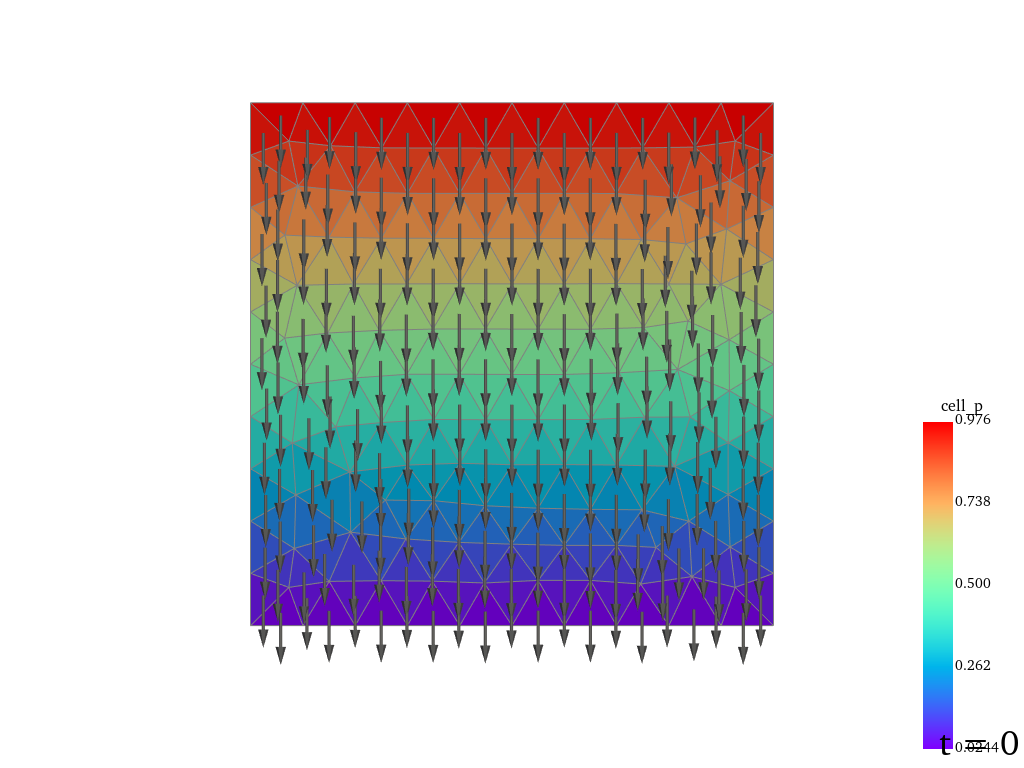

In [ ]:
# NBIGNORE
vis = pg.Visualizer(file_name, folder_name)
vis.vector_field("cell_q", scaling_factor=0.05)
vis.scalar_field("cell_p")
vis.show()


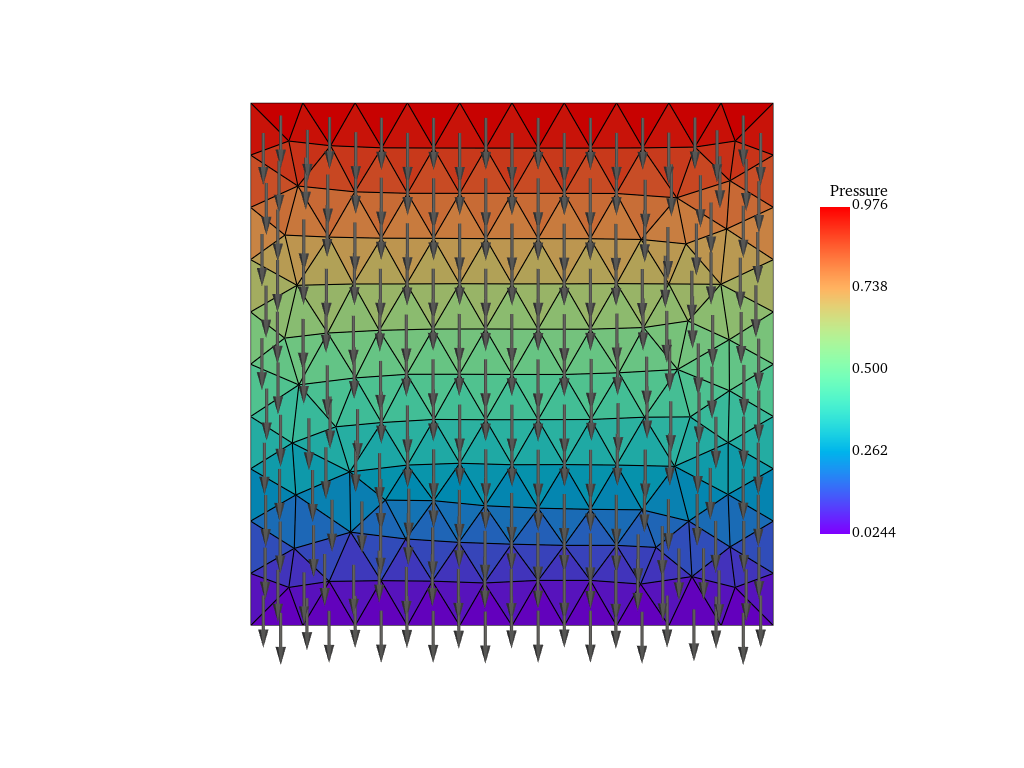

In [9]:
# NBIGNORE


import pyvista as pv

file_vtu = os.path.join(folder_name, file_name + "_2.vtu")
mesh = pv.read(file_vtu)

plotter = pv.Plotter(off_screen=True, notebook=True)

# Glyphs scaled by magnitude
arrows = mesh.glyph(orient="cell_q", scale="cell_q", factor=0.05)
plotter.add_mesh(arrows, color="gray")

# Mesh colored by pressure
bar = {"title": "Pressure", "vertical": True, "position_x": 0.8, "position_y": 0.3}
plotter.add_mesh(
    mesh, scalars="cell_p", cmap="rainbow", show_edges=True, scalar_bar_args=bar
)

# Show the result
plotter.view_xy()
plotter.enable_parallel_projection()
plotter.show(jupyter_backend="static")


In [10]:
# Consistency check
assert np.isclose(np.linalg.norm(q), 2.7448443893910275)
assert np.isclose(np.linalg.norm(p), 0.037554643969992293)